# This is a test of this jupyter notebook in combiantion with Snorkel

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import XMLMultiDocParser

xml_parser = XMLMultiDocParser(
    path='data/CDR_TrainingSet.BioC.xml',
    doc='.//document',
    text='.//passage/text/text()',
    id='.//id/text()')

In [3]:
from snorkel.parser import SentenceParser
from utils import CDRTagger

cdr_tagger = CDRTagger()
cdr_sent_parser = SentenceParser(fn=cdr_tagger.tag)

/home/davidnicholson/anaconda3/envs/p27/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[========================================] 100%

Number of documents: 500
CPU times: user 8.76 s, sys: 192 ms, total: 8.96 s
Wall time: 1min 28s


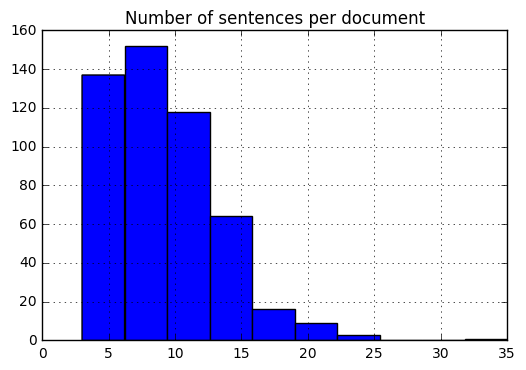

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(xml_parser, cdr_sent_parser, max_docs=500)
%time corpus = cp.parse_corpus(name='CDR Train', session=session)

In [5]:
session.add(corpus)
session.commit()

Create a Candidate Parser!!

In [6]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

In [7]:
from snorkel.candidates import PretaggedCandidateExtractor

ce = PretaggedCandidateExtractor(ChemicalDisease, ['Chemical', 'Disease'])

In [8]:
from snorkel.models import Corpus

for corpus_name in ['CDR Train']:
    corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
    sentences = set()
    for document in corpus:
        for sentence in document.sentences:
            sentences.add(sentence)
    
    %time c = ce.extract(sentences, corpus_name + ' Candidates', session)
    session.add(c)
    print '{0} has {1} candidates'.format(corpus_name, len(c))
session.commit()

[========================================] 100%

CPU times: user 15.3 s, sys: 72 ms, total: 15.4 s
Wall time: 15.5 s
CDR Train has 4637 candidates


Time to Use our specialized label functions!! Then train a Naivebayes Model

In [9]:
from snorkel.models import CandidateSet

train = session.query(CandidateSet).filter(CandidateSet.name == 'CDR Train Candidates').one()

In [10]:
#write my own tsv parser
import pandas as pd
drugs = pd.read_csv('data/PharmcoDB/drugs.tsv',sep="\t")
drug_names = set(drugs["drug"].str.lower())

In [11]:
import re,sys
from snorkel.lf_helpers import (
    get_tagged_text,
    get_text_between,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

def LF_is_in_PharmDB(c):
    return 1 if " ".join(c[0].get_attrib_tokens()) in drug_names else 0



In [12]:
LFs = [LF_is_in_PharmDB]

In [13]:
from snorkel.annotations import LabelManager

label_manager = LabelManager()

In [14]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%

Loading sparse Label matrix...
CPU times: user 13.5 s, sys: 64 ms, total: 13.6 s
Wall time: 13.8 s


<4637x1 sparse matrix of type '<type 'numpy.float64'>'
	with 1411 stored elements in Compressed Sparse Row format>

In [35]:
import numpy as np
fake = np.random.choice([-1,1],[4637])
fake
print fake.shape
#print L_train
#L_train.lf_stats()
L_train.lf_stats(labels=np.transpose(fake))

(4637,)


,j,coverage,overlaps,conflicts,accuracy,tp,fp,fn,tn
LF_is_in_PharmDB,0,0.304292,0.0,0.0,0.492558,695,716,0,0


In [125]:
from snorkel.learning import NaiveBayes
bayes_model = NaiveBayes()
bayes_model.train(L_train)

Training marginals (!= 0.5):	4637
Features:			1
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-06 after 10 steps


In [ ]:
#for debugging purposes
#print c
#print c[0]
#print
#print c[0].parent.text
#print
#print c[0].parent.words
#print
#print c[0].parent.pos_tags
#print
#print c[0].parent.dep_parents
#print
#print c[0].parent.dep_labels
#print
#print " ".join(c[0].get_attrib_tokens())
#sys.exit(10)

#in annotations.py
#line 184
#                print value
#                if i == 6:
#                    session.rollback()
#                    sys.exit(1)

#line 180
#            print candidate
#            print